In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import minmax_scale

from scipy.stats import norm

# Download the date
https://archive.ics.uci.edu/ml/machine-learning-databases/00577/codon_usage.csv.zip


In [2]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00577/codon_usage.csv.zip

In [3]:
# !unzip codon_usage.csv.zip

In [4]:
def read_data(file_name):
    """
    Reads in a csv file and returns a dataframe
    """
    return pd.read_csv(file_name, low_memory=False)

dataset = read_data('codon_usage.csv')
df = dataset.copy()

In [5]:
# dataset = read_data('codon_usage.csv')
dataset.describe()

,DNAtype,SpeciesID,Ncodons,UUA,UUG,CUU,CUC,CUA,CUG,AUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
count,13028.000000,13028.000000,1.302800e+04,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,...,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000,13028.000000
mean,0.367209,130451.105926,7.960576e+04,0.020637,0.014104,0.017820,0.018288,0.019044,0.018450,0.028352,...,0.005454,0.009929,0.006422,0.024178,0.021164,0.028290,0.021683,0.001645,0.000592,0.006178
std,0.688726,124787.086107,7.197010e+05,0.020709,0.009280,0.010586,0.014572,0.024250,0.016578,0.017507,...,0.006605,0.008574,0.006387,0.013828,0.013041,0.014342,0.015018,0.001834,0.000907,0.010344
min,0.000000,7.000000,1.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28850.750000,1.602000e+03,0.005610,0.007108,0.010890,0.007830,0.005307,0.007180,0.016360,...,0.001220,0.001690,0.001170,0.012380,0.011860,0.017360,0.009710,0.000560,0.000000,0.000410
50%,0.000000,81971.500000,2.927500e+03,0.015260,0.013360,0.016130,0.014560,0.009685,0.012800,0.025475,...,0.003530,0.009270,0.004545,0.025420,0.019070,0.026085,0.020540,0.001380,0.000420,0.001130
75%,1.000000,222891.250000,9.120000e+03,0.029485,0.019810,0.022730,0.025112,0.017245,0.024315,0.038113,...,0.007150,0.015922,0.010250,0.034190,0.027690,0.036800,0.031122,0.002370,0.000830,0.002890
max,12.000000,465364.000000,4.066258e+07,0.151330,0.101190,0.089780,0.100350,0.163920,0.107370,0.154060,...,0.055540,0.098830,0.058430,0.185660,0.113840,0.144890,0.158550,0.045200,0.025610,0.106700


In [6]:
dataset

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,pri,0,9601,1097,Pongo pygmaeus abelii,0.02552,0.03555,0.00547,0.01367,0.01276,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,pri,1,9601,2067,mitochondrion Pongo pygmaeus abelii,0.01258,0.03193,0.01984,0.00629,0.01451,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,pri,1,9602,1686,mitochondrion Pongo pygmaeus pygmaeus,0.01423,0.03321,0.01661,0.00356,0.01127,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,pri,0,9606,40662582,Homo sapiens,0.01757,0.02028,0.00767,0.01293,0.01319,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


In [7]:
# dataset.dropna(inplace=True)

dataset['Kingdom'].value_counts()

bct    2920
vrl    2832
pln    2523
vrt    2077
inv    1345
mam     572
phg     220
rod     215
pri     180
arc     126
plm      18
Name: Kingdom, dtype: int64

In [8]:
print(dataset.isnull().sum())

Kingdom        0
DNAtype        0
SpeciesID      0
Ncodons        0
SpeciesName    0
              ..
GAA            0
GAG            0
UAA            0
UAG            0
UGA            0
Length: 69, dtype: int64


<AxesSubplot:>

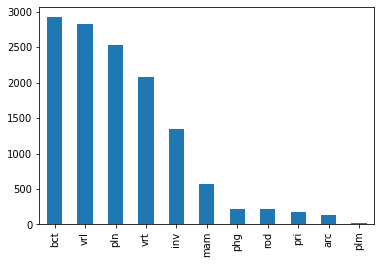

In [9]:
dataset['Kingdom'].value_counts().plot(kind='bar')

In [10]:
dataset['Kingdom'].unique()

array(['vrl', 'arc', 'bct', 'phg', 'plm', 'pln', 'inv', 'vrt', 'mam',
       'rod', 'pri'], dtype=object)

In [11]:
# dataset['organism_kingdom'] = dataset['Kingdom'].copy()

In [12]:
dataset['Kingdom'] = dataset['Kingdom'].map({   'arc': 0, 'bct': 0, 
                                                'phg': 1, 'plm': 0, 'vrl':0, 
                                                'pln': 1, 'inv': 1, 
                                                'vrt': 1, 'mam': 1,
                                                'rod': 1, 'pri': 1})

<AxesSubplot:>

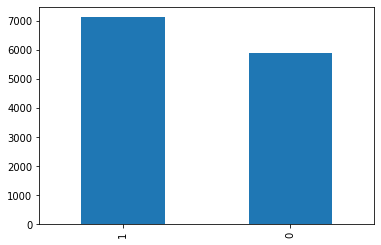

In [13]:
dataset['Kingdom'].value_counts().plot(kind='bar')

In [14]:
dataset = dataset.drop(dataset[dataset['SpeciesID']==353569].index)
dataset = dataset.drop(dataset[dataset['SpeciesID']==1238].index)

# dataset[dataset['SpeciesID']==353569]

In [15]:
dataset['UUU'] = dataset['UUU'].astype(float)
dataset['UUC'] = dataset['UUC'].astype(float)
# dataset = minmax_scale(dataset)
cols = dataset.select_dtypes(np.number).columns

num_columns_list = list(cols)
# num_columns_list

num_columns_list.remove('Kingdom')
num_columns_list.remove('DNAtype')
num_columns_list.remove('SpeciesID')
num_columns_list.remove('Ncodons')
# num_columns_list

In [16]:
for num_column in num_columns_list:
    dataset[num_column] = minmax_scale(dataset[num_column])


In [17]:
dataset.head()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,0,0,100217,1995,Epizootic haematopoietic necrosis virus,0.076116,0.131203,0.003304,0.034687,0.133994,...,0.081203,0.131843,0.609105,0.054023,0.405130,0.083029,0.275055,0.055531,0.019524,0.000000
1,0,0,100220,1474,Bohle iridovirus,0.124896,0.147999,0.004493,0.067003,0.045333,...,0.024487,0.171608,0.615437,0.065765,0.399245,0.107668,0.278146,0.059956,0.026552,0.000000
2,0,0,100755,4862,Sweet potato leaf curl virus,0.090842,0.237758,0.089672,0.152485,0.087102,...,0.107310,0.199737,0.425980,0.168372,0.178848,0.154738,0.155661,0.086504,0.000000,0.013496
3,0,0,100880,1915,Northern cereal mosaic virus,0.081684,0.244847,0.106985,0.098033,0.174538,...,0.065898,0.142669,0.285983,0.202521,0.169712,0.209055,0.217345,0.057743,0.061304,0.000000
4,0,0,100887,22831,Soil-borne cereal mosaic virus,0.129590,0.149526,0.050684,0.363573,0.153709,...,0.108750,0.151169,0.296765,0.223419,0.218113,0.231831,0.232040,0.000000,0.017181,0.012277


In [18]:
X = dataset.iloc[:, 5:-1].values.astype(float)
y = dataset.iloc[:, 0]


In [19]:
y

0        0
1        0
2        0
3        0
4        0
        ..
13023    1
13024    1
13025    1
13026    1
13027    1
Name: Kingdom, Length: 13026, dtype: int64

In [20]:
class DataGenerator:

    def __init__(self, X, y, sampleSize=16):
        self.X = X
        self.y = y
        self.sampleSize = sampleSize
        if self.sampleSize <= 0 and self.sampleSize > len(self.X):
            return TypeError("sampleSize must be between 0 and ", len(X))



    def split_data(self, test_size=0.3, random_state=1):
        self.X_train, self.X_rem, self.y_train, self.y_rem = tts(self.X, self.y, test_size=test_size, random_state=random_state)
        self.X_test, self.X_val, self.y_test, self.y_val = tts(self.X_rem, self.y_rem, test_size=0.5, random_state=random_state)
        return self.X_train, self.X_test, self.y_train, self.y_test

    
    # def training_data_generator(self):
    #     # print(len(self.X))
    #     idx = np.random.randint(0, len(self.X_train), self.sampleSize)
    #     if self.sampleSize <= 0 and self.sampleSize > len(self.X):
    #         return TypeError("sampleSize must be between 0 and ", len(self.X))
    #     train_X, train_y = self.X_train[idx], self.y_train[idx]
    #     yield train_X
    #     yield train_y
    
    # def validation_data_generator(self):
    #     idx = np.random.randint(0, len(self.X_rem), self.sampleSize)
    #     if self.sampleSize <= 0 and self.sampleSize > len(self.X):
    #         return TypeError("sampleSize must be between 0 and ", len(self.X_rem))
    #     test_X, test_y = self.X[idx], self.y[idx]
    #     # return test_X, test_y
    #     yield test_X
    #     yield test_y
    

In [21]:
data_generator = DataGenerator(y=y, X=X)

In [22]:
X_training, X_testing, y_training, y_testing = data_generator.split_data()

In [23]:
class SingleVsMultiModel:
  def __init__(self, X_train, X_test, y_train, y_test, laplace_smoothing_value, laplace, total_classes=2):
    self.laplace_smoothing_value = laplace_smoothing_value
    self.laplace = laplace
    self.total_classes = total_classes
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def fitDistribution(self, data):
    mean = np.mean(data)
    std = np.std(data)
    dist = norm(mean, std)
    return dist


  def laplaceSmoothing(self, class0, class1):
    smooth0 = (class0 + self.laplace_smoothing_value) / ( (class0.size) + self.laplace_smoothing_value * self.n_features)
    smooth1 = (class1 + self.laplace_smoothing_value) / ( (class1.size) + self.laplace_smoothing_value * self.n_features)

    return smooth0, smooth1


  def evaluate(self, y, y_predicted):
    '''

      Takes original classes and predicted classes as input

      Return the values of precision, recall and accuracy
    
    '''
    y = ( y==1 )
    y_predicted = ( y_predicted == 1 )

    precision = (y&y_predicted).sum() / y_predicted.sum()
    recall = (y&y_predicted).sum() / y.sum()
    accuracy = (y==y_predicted).sum() / y.size


    return precision, recall, accuracy
  

  def probability(self, data):
    py0 = 1
    py1 = 1

    for i in range(self.n_features):
      py0 *= self.features['X'+str(i)+'0'].pdf(data[i])
      py1 *= self.features['X'+str(i)+'1'].pdf(data[i])

    
    return  py0 * self.prior_0, py1 * self.prior_1


  def laplaceProbability(self, data):
    py0 = 1
    py1 = 1

    for i in range(self.n_features):
      pdf0 = self.features['X'+str(i)+'0'].pdf(data[i])
      pdf1 = self.features['X'+str(i)+'1'].pdf(data[i])
      smooth0 , smooth1 = self.laplaceSmoothing(pdf0, pdf1)
      py0 *= smooth0
      py1 *= smooth1

    return  py0 * self.prior_0, py1 * self.prior_1                                                                             




  def fit(self):

    X0_train = self.X_train[self.y_train == 0]
    X1_train = self.X_train[self.y_train == 1]

    self.prior_1 = len(X1_train) / len(self.X_train)
    self.prior_0 = len(X0_train) / len(self.X_train)

    self.n_features = self.X_train.shape[1]
    self.features = {}
    
    for i in range(self.n_features):
      self.features['X'+str(i)+'0'] = self.fitDistribution(X0_train[:, i])
      self.features['X'+str(i)+'1'] = self.fitDistribution(X1_train[:, i])


  
  
  def predict(self):
    count = 0
    y_predicted = []
    y = []
    for sample, target in zip(self.X_test, self.y_test):

      if self.laplace:
        py0, py1 = self.laplaceProbability(sample)
      
      else:
        py0, py1 = self.probability(sample)

      # print("Model predicted class {} and truth was {}".format(np.argmax([py0,py1]), target))
      y_predicted.append(np.argmax([py0,py1]))
      y.append(target)
      # np.append(y_predicted, np.argmax([py0,py1]))
      # np.append(y, target)
      # y = target
      if np.argmax([py0,py1]) != target :
        count+=1

      # precision, recall, accuracy = self.evaluate(y, y_predicted)
      # print("precision:", precision)
      # print("recall:", recall)
      # print("accuracy:", accuracy)

    
    print(count)
    # print(y)
    y_predicted = np.array(y_predicted)
    y = np.array(y)

    precision, recall, accuracy = self.evaluate(y, y_predicted)
    print("precision:", precision)
    print("recall:", recall)
    print("accuracy:", accuracy)

    return y_predicted, y


In [24]:
clf = SingleVsMultiModel(X_train= X_training, X_test=X_testing, y_train= y_training,y_test=y_testing, laplace_smoothing_value=0.5, laplace=True)

In [25]:
clf.fit()

In [26]:
y_predicted, y = clf.predict()

568
precision: 0.8569277108433735
recall: 0.5460652591170825
accuracy: 0.7093142272262026


In [27]:
print(y_predicted)
print(y)

[0 1 1 ... 0 1 1]
[1 1 1 ... 1 1 0]
